# Generating random 2D projections

***
This notebook makes it possible to generate 2D projections of MULTIGRIS/SFGX results. 

MULTIGRIS determines the properties of several sectors with different covering factors which correspond to the fraction of the solid angle around the stellar cluster. 

The idea is to provide a more "realistic" representation of the result by using random 3D angles distributed according to the sector covering factors (mixing weights). One cube is created per tracer in order to make, once projected, an RGB figure.  

We'll use an n-dimensional gradient noise to distribute the sector angles. 
- https://ronvalstar.nl/creating-tileable-noise-maps
- https://pypi.org/project/perlin-noise/
- https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401
- https://pynoise.readthedocs.io/en/latest/tutorial7.html
***

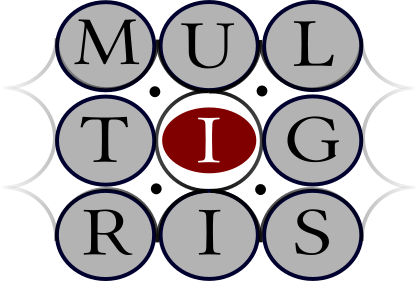

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import Image
Image(filename='../../Images/logo.png') 

## Imports
***

In [2]:
from PIL import Image # Depends on the Pillow lib
import numpy as np
from opensimplex import OpenSimplex
from math import sin, cos, pi, atan2, acos
import matplotlib.pyplot as plt
import pyvista as pv
from scipy.interpolate import interp1d
from copy import deepcopy
import h5py
from tqdm import tqdm

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

from astropy.constants import c
from Library.create_postprocessing_table import merge_fix_cols, get_depth_transitions

Some local parameters

In [3]:
path_to_models = '/local/home/vleboute/ownCloud/MULTIGRIS/'

Function to convert cut into depth

In [4]:
def cut2depth(h5file, cut=0):
    df = pd.read_hdf(h5file, key='main', mode='r+')
    df = merge_fix_cols(df)
    X = df['#depth']
    list_of_species = ['H1+','H_2H_2/H']         
    npoints = 3
    depths = get_depth_transitions(df, X, list_of_species, npoints)
    cuts = np.linspace(0, 4, len(depths))
    return interp1d(cuts, depths)(cut)

Function to rebin 1D array

In [5]:
def rebin( a, newshape ):
        '''Rebin an array to a new shape.
        '''
        assert len(a.shape) == len(newshape)

        slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
        coordinates = np.mgrid[slices]
        indices = coordinates.astype('i')   #choose the biggest smaller integer index
        return a[tuple(indices)]

## Examples
***

Rectangular 2D example

In [6]:
WIDTH = 500
HEIGHT = WIDTH

simplex = OpenSimplex(seed=2)

print('Generating 2D image...')
im = Image.new('L', (WIDTH, HEIGHT))
coeffs = [1, 0.2]
FEATURE_SIZE = [100, 10]
for y in range(0, HEIGHT):
    for x in range(0, WIDTH):
        #octaves
        value = np.sum([coeffs[i]*simplex.noise2(x / FEATURE_SIZE[i], y / FEATURE_SIZE[i]) for i in range(len(coeffs))])
        value /= np.sum(coeffs)
        color = int((value + 1) * 128)
        im.putpixel((x, y), color)
im.show()

Generating 2D image...


# Actual calculation

Spherical 2D example (rectangular projection of the sphere's surface)

-1.1106686280092233 1.1290582344129556


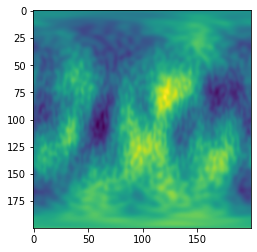

In [7]:
WIDTH = 200
HEIGHT = WIDTH

simplex = OpenSimplex() #seed=2

#im = Image.new('L', (WIDTH, HEIGHT))
im2 = np.zeros([WIDTH, HEIGHT])
coeffs = [1, 0.5, 0.2]
FEATURE_SIZE = [1, 0.5, 0.1]
for y in range(0, HEIGHT):
    for x in range(0, WIDTH):
        x2 = (x+0.5)/WIDTH * 2.*pi
        y2 = (y+0.5)/HEIGHT * pi
        z2 = sin(y2+pi)
        a = sin(x2)*z2
        b = cos(x2)*z2
        c = cos(y2)
        value = np.sum([coeffs[i]*simplex.noise3(a / FEATURE_SIZE[i], b / FEATURE_SIZE[i], c / FEATURE_SIZE[i]) for i in range(len(coeffs))])
        #value = np.sum([coeffs[i]*simplex.noise3d(123+a / FEATURE_SIZE[i], 132+b / FEATURE_SIZE[i], 312+c / FEATURE_SIZE[i]) for i in range(len(coeffs))])
        value /= np.sum(coeffs)
        im2[y, x] = 2*value
        #color = int((value + 0.5) * 128)
        #im.putpixel((x, y), color)
#im.show()
im2 = np.array(im2)
plt.imshow(im2)
print(im2.min(), im2.max())

We'll use threshold values to choose what sector each pixel corresponds to, as illustrated below

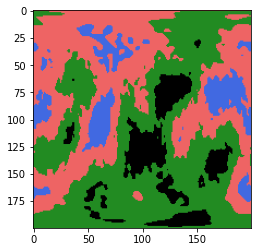

In [8]:
blue = [65,105,225]
green = [34,139,34]
red = [238, 100, 100]

def add_color(projection):
    color_projection = np.zeros(projection.shape+(3,))
    for i in range(projection.shape[0]):
        for j in range(projection.shape[1]):
            if projection[i][j] < -0.5:
                color_projection[i][j] = blue
            elif projection[i][j] < 0:
                color_projection[i][j] = red
            elif projection[i][j] < 0.5:
                color_projection[i][j] = green

    return color_projection

color_pic = add_color(im2)
plt.imshow(color_pic.astype('uint8'))

Map the spherical 2D map on a sphere

/local/home/vleboute/miniconda3/lib/python3.9/site-packages/pyvista/core/dataset.py:1541: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(
/local/home/vleboute/miniconda3/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


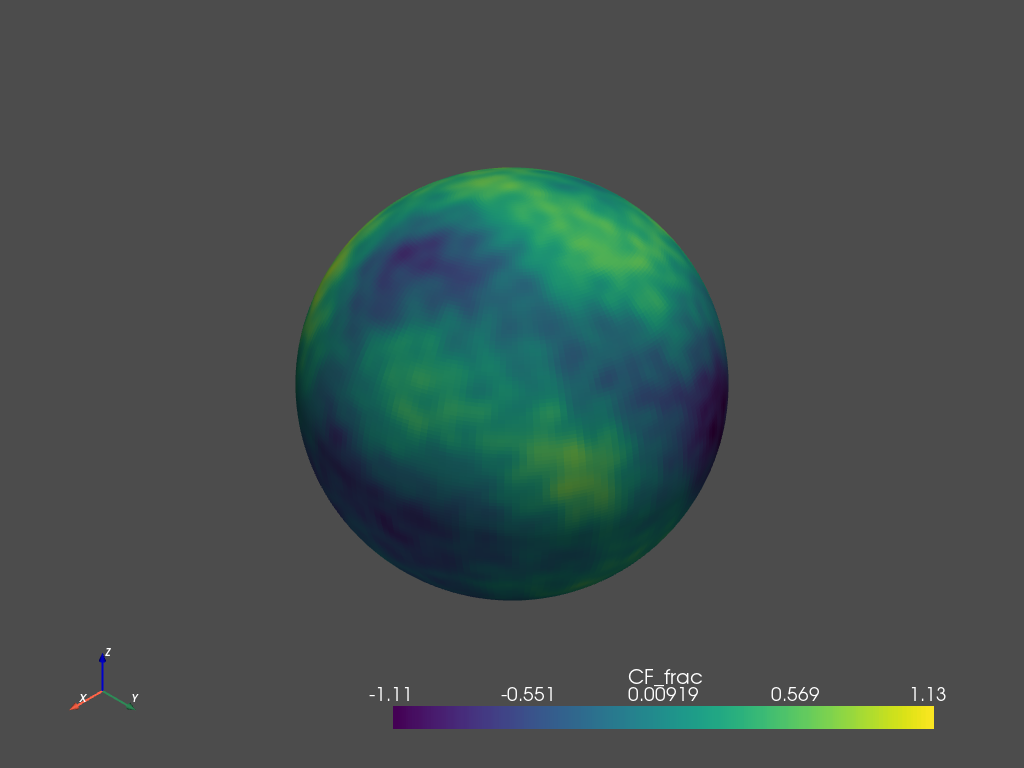

In [9]:
xx, yy, zz = np.meshgrid(np.radians(np.linspace(0, 360, WIDTH+1)), 
                         np.radians(np.linspace(-90, 90, WIDTH+1)), 
                         [0])

# Transform to spherical coordinates
radius = 1
x = radius * np.cos(yy) * np.cos(xx)
y = radius * np.cos(yy) * np.sin(xx)
z = radius * np.sin(yy)

grid = pv.StructuredGrid(x, y, z)

grid.cell_arrays['CF_frac'] = im2.ravel(order='F')

grid.plot()

## Application
***

Read the HDF5 files, choose some tracers, and get the fluxes per zone

In [10]:
files = [path_to_models + 'lum9_age3Myr_n3_u-2_z0.1_Lx0.01_Tx6.hdf5', 
         path_to_models + 'lum9_age3Myr_n1_u-3_z0.1_Lx0.01_Tx6.hdf5', 
         path_to_models + 'lum9_age3Myr_n2_u-2_z0.1_Lx0.01_Tx6.hdf5',         
         ]

In [11]:
with h5py.File(files[0], 'r') as f:
    print(f.keys())  # works like a dict

<KeysViewHDF5 ['H2_cd', 'cont', 'ion_cont', 'lines', 'main', 'thermal_processes']>


In [12]:
f = pd.read_hdf(files[0], key='main', mode='r')
f

#depth         TauIn        TauTot   n(2p)/n(1s)    Texc      Te_x    Tex/T          Pesc      Pdes          pump       opacity  albedo  \
0     1.632700e+12  1.828000e-02  3.088000e+11  3.271000e-14  3681.0  23720.00   0.1552  5.000000e-01  0.000010  9.277000e-06  3.585000e-21  0.5226   
1     9.796190e+12  9.133000e-02  3.088000e+11  3.319000e-14  3683.0  23720.00   0.1553  4.761000e-01  0.000011  8.932000e-06  3.585000e-21  0.5224   
2     4.245020e+13  3.835000e-01  3.088000e+11  3.504000e-14  3689.0  23710.00   0.1556  3.997000e-01  0.000011  7.805000e-06  3.585000e-21  0.5224   
3     1.730660e+14  1.554000e+00  3.088000e+11  4.081000e-14  3707.0  23690.00   0.1565  2.435000e-01  0.000011  5.254000e-06  3.585000e-21  0.5224   
4     4.133990e+14  3.079000e+00  3.088000e+11  6.028000e-14  3753.0  23630.00   0.1588  9.492000e-02  0.000011  2.606000e-06  3.586000e-21  0.5227   
...            ...           ...           ...           ...     ...       ...      ...           ...       ...           ...           ...     ...   
1454  9.251840e+18  2.834000e+11  3.088000e+11  1.383000e-18  2803.0     35.81  78.2700  3.449000e-13  0.000001  2.211000e-19  4.732000e-16  0.4007   
1455  9.254010e+18  2.835000e+11  3.088000e+11  1.328000e-18  2800.0     37.33  75.0200  3.455000e-13  0.000001  2.167000e-19  4.727000e-16  0.3974   
1456  9.255930e+18  2.835000e+11  3.088000e+11  1.293000e-18  2799.0     38.38  72.9300  3.459000e-13  0.000001  2.180000e-19  4.723000e-16  0.3952   
1457  9.257990e+18  2.835000e+11  3.088000e+11  1.305000e-18  2799.0     37.86  73.9300  3.463000e-13  0.000001  2.194000e-19  4.737000e-16  0.3956   
1458  9.259250e+18  2.835000e+11  3.088000e+11  1.302000e-18  2799.0     37.81  74.0300  3.468000e-13  0.000001  2.185000e-19  4.748000e-16  0.3952   

      AL 2 2660.35A_x  AL 2 2669.15A_x  AL 9 2.04444m_x  AR 2 6.98337m_x  AR 3 21.8253m_x  AR 3 3109.18A_x  AR 3 5191.82A_x  AR 3 6.36676m_x  \
0        3.223800e+30     2.279900e+30              0.0     3.219600e+29     1.336500e+31     4.637100e+31     2.141500e+31     2.401200e+28   
1        1.606900e+31     1.136300e+31              0.0     1.605000e+30     6.667500e+31     2.312300e+32     1.067900e+32     1.197900e+29   
2        6.740400e+31     4.766500e+31              0.0     6.731700e+30     2.797400e+32     9.698700e+32     4.479000e+32     5.025600e+29   
3        2.725100e+32     1.927100e+32              0.0     2.722000e+31     1.131000e+33     3.916700e+33     1.808800e+33     2.031900e+30   
4        5.382000e+32     3.806300e+32              0.0     5.368300e+31     2.229400e+33     7.704300e+33     3.558000e+33     4.005300e+30   
...               ...              ...              ...              ...              ...              ...              ...              ...   
1454     1.367600e+37     1.229500e+37              0.0     1.301600e+37     2.304100e+37     3.790500e+37     1.750500e+37     4.139500e+34   
1455     1.367600e+37     1.229500e+37              0.0     1.301600e+37     2.304100e+37     3.790500e+37     1.750500e+37     4.139500e+34   
1456     1.367600e+37     1.229500e+37              0.0     1.301600e+37     2.304100e+37     3.790500e+37     1.750500e+37     4.139500e+34   
1457     1.367600e+37     1.229500e+37              0.0     1.301600e+37     2.304100e+37     3.790500e+37     1.750500e+37     4.139500e+34   
1458     1.367600e+37     1.229500e+37              0.0     1.301600e+37     2.304100e+37     3.790500e+37     1.750500e+37     4.139500e+34   

      AR 3 7135.79A_x  AR 3 7751.11A_x  AR 3 8.98898m_x  AR 4 2853.66A_x  AR 4 2868.22A_x  AR 4 4711.26A_x  AR 4 4740.12A_x  AR 4 7170.70A_x  \
0        5.407800e+32     1.283700e+32     1.862800e+32     1.772700e+32     7.907900e+31     5.649600e+32     4.351900e+32     2.512000e+31   
1        2.697300e+33     6.402800e+32     9.292800e+32     8.860700e+32     3.952800e+32     2.824500e+33     2.175700e+33     1.255600e+32   
2        1.131600e+34     2.686100e+33

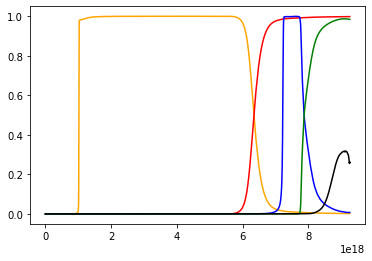

In [13]:
plt.plot(f['#depth'], f['HI'], color='orange')
plt.plot(f['#depth'], f['2H_2/H'], color='red')
plt.plot(f['#depth'], f['CI/C'], color='blue')
plt.plot(f['#depth'], f['CO/C_x'], color='green')
plt.plot(f['#depth'], 1e2*f['H2O/O_x'], color='black')
plt.xscale('linear')

In [14]:
f = [pd.read_hdf(ff, key='main', mode='r+') for ff in files]
print([t for t in f[0].keys()])

labels = ('O  3 5006.84A_x', 'S  2 6716.44A_x', 'C  2 157.636m_x') #('O  1 63.1679m_x', 'S  2 6716.44A_x', 'C  2 157.636m_x') # 'O  3 5006.84A_x',
for s in range(2):
    for label in labels:
        f[s][label] = f[s][label]-np.roll(f[s][label], 1)
        f[s][label][0] = f[s][label][1]

['#depth', 'TauIn', 'TauTot', 'n(2p)/n(1s)', 'Texc', 'Te_x', 'Tex/T', 'Pesc', 'Pdes', 'pump', 'opacity', 'albedo', 'AL 2 2660.35A_x', 'AL 2 2669.15A_x', 'AL 9 2.04444m_x', 'AR 2 6.98337m_x', 'AR 3 21.8253m_x', 'AR 3 3109.18A_x', 'AR 3 5191.82A_x', 'AR 3 6.36676m_x', 'AR 3 7135.79A_x', 'AR 3 7751.11A_x', 'AR 3 8.98898m_x', 'AR 4 2853.66A_x', 'AR 4 2868.22A_x', 'AR 4 4711.26A_x', 'AR 4 4740.12A_x', 'AR 4 7170.70A_x', 'AR 4 7237.77A_x', 'AR 4 7263.33A_x', 'AR 5 13.0985m_x', 'AR 5 6435.12A_x', 'AR 5 7.89971m_x', 'AR 5 7005.83A_x', 'AR 6 4.52800m_x', 'C  1 1.06950m_x', 'C  1 370.269m_x', 'C  1 609.590m_x', 'C  1 8727.13A_x', 'C  1 9088.00A_x', 'C  1 9850.26A_x', 'C  2 157.636m_x', 'C  2 2837.00A_x', 'C  2 4267.00A_x', 'C  2 6578.05A_x', 'C  2 6582.88A_x', 'C  2 9903.00A_x', 'C  3 2512.20A_x', 'C  3 4069.00A_x', 'C  3 4649.00A_x', 'C  4 4659.00A_x', 'CO   1300.05m_x', 'CO   2600.05m_x', 'CO   325.137m_x', 'CO   371.549m_x', 'CO   433.438m_x', 'CO   520.089m_x', 'CO   650.074m_x', 'CO   866.7

/tmp/ipykernel_248936/2940058133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f[s][label][0] = f[s][label][1]


Compress some rows to get the right fraction of pixels

In [15]:
ftheta = interp1d(np.arange(WIDTH), np.radians(np.linspace(-90, 90, WIDTH)), fill_value='extrapolate')
tmp = [rebin(r, np.array([WIDTH*np.abs(cos(ftheta(i)))])) for i,r in enumerate(im2)]
print([len(t) for t in tmp])

[1, 4, 7, 10, 13, 16, 19, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 54, 57, 60, 63, 66, 69, 72, 74, 77, 80, 83, 86, 89, 92, 95, 97, 100, 103, 105, 108, 111, 113, 116, 119, 121, 124, 126, 129, 131, 133, 136, 138, 140, 142, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 166, 168, 170, 172, 173, 175, 176, 178, 179, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 195, 196, 197, 197, 198, 198, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 199, 199, 199, 198, 198, 197, 197, 196, 195, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 183, 182, 181, 179, 178, 176, 175, 173, 172, 170, 168, 166, 165, 163, 161, 159, 157, 155, 153, 151, 149, 147, 145, 142, 140, 138, 136, 133, 131, 129, 126, 124, 121, 119, 116, 113, 111, 108, 105, 103, 100, 97, 95, 92, 89, 86, 83, 80, 77, 74, 72, 69, 66, 63, 60, 57, 54, 50, 47, 44, 41, 38, 35, 32, 29, 26, 23, 19, 16, 13, 10, 7, 4, 1]


Example with 3 sectors

In [16]:
n_sectors = 3
cfs = [0.1, 0.3, 0.6] #ascending
fracs = np.zeros(n_sectors)

#eventually replace with tmp
for i,cf in enumerate(cfs):
    fracs[i] = -1
    while len(np.where(im2.flatten()>fracs[i])[0])/len(im2.flatten())>np.sum(cfs[0:i]):
        fracs[i] += 0.1
    print(cf, fracs[i])
    
def getsector(value):
    for s in range(n_sectors):
        if value>fracs[s]:
            return s

0.1 1.2
0.3 0.5999999999999999
0.6 0.19999999999999987


Show sectors on sphere

/local/home/vleboute/miniconda3/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


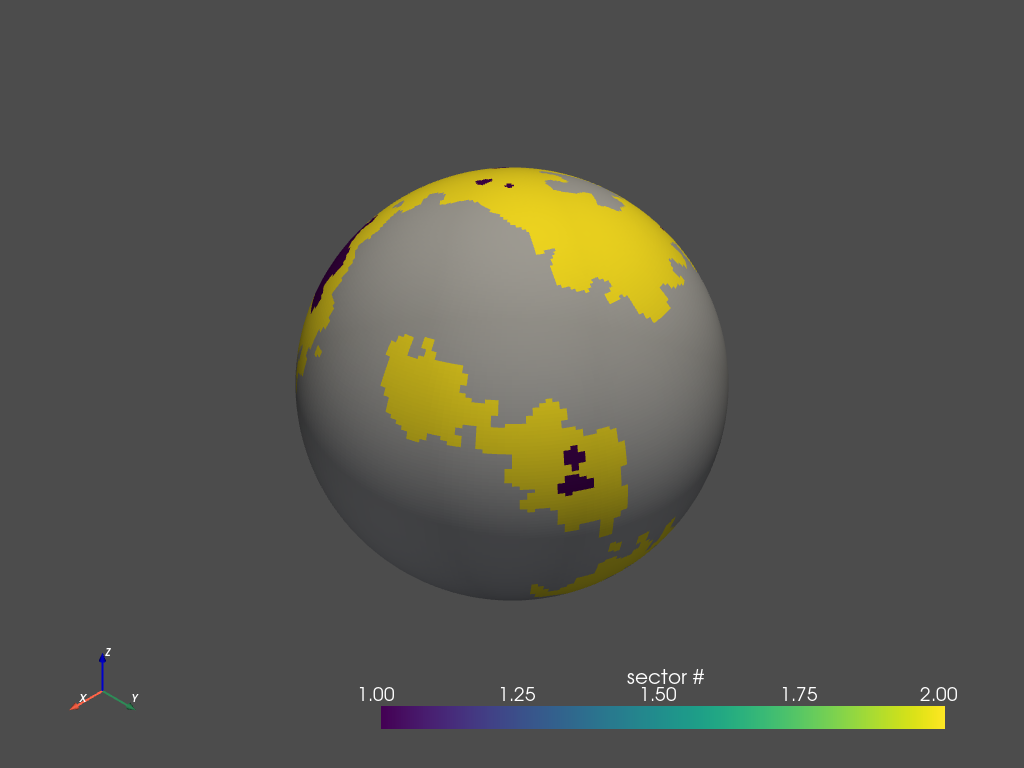

In [17]:
xx, yy, zz = np.meshgrid(np.radians(np.linspace(0, 360, WIDTH+1)), 
                         np.radians(np.linspace(-90, 90, WIDTH+1)), 
                         [0])

# Transform to spherical coordinates
radius = 1
x = radius * np.cos(yy) * np.cos(xx)
y = radius * np.cos(yy) * np.sin(xx)
z = radius * np.sin(yy)

grid = pv.StructuredGrid(x, y, z)

im3 = deepcopy(im2)
for j,col in enumerate(im3):
    for i,row in enumerate(col):
        im3[j,i] = getsector(im2[j,i])
grid.cell_data['sector #'] = im3.ravel(order='F')

grid.plot()

Main calculation

In [18]:
rin = 20*np.array([0.9e19, 0.85e19, 0.8e19]) #eventually get from input/output files

cuts = [2, 0.75, 1.25] #eventually get from result files
depths = [cut2depth(files[s], cuts[s]) for s in range(n_sectors)]
rmax = np.max([rin[s]+depths[s] for s in range(n_sectors)])

print(rin)
print(depths)
print(rmax)

cube = np.zeros([3, WIDTH, WIDTH, WIDTH])
x0, y0, z0 = 0.5*np.array(cube.shape[1:])-0.5

print(im2.shape)
print(x0, y0, z0)

[1.8e+20 1.7e+20 1.6e+20]
[array(5.6479184e+18), array(1.31962207e+19), array(9.63984126e+18)]
1.856479184e+20
(200, 200)
99.5 99.5 99.5


make sure that depth is significant wrt radius otherwise tracers that emit in tiny shells won't show in the cube

In [19]:
fphi = interp1d(np.linspace(0, 360, WIDTH), np.arange(WIDTH), fill_value='extrapolate')
ftheta = interp1d(np.linspace(0, 180, WIDTH), np.arange(WIDTH), fill_value='extrapolate')
fr = [interp1d(f[s]['#depth'], np.arange(len(f[s]['#depth'])), fill_value='extrapolate') for s in range(n_sectors)]
tmp = np.zeros([WIDTH, WIDTH])
for x in tqdm(range(cube.shape[1])):
    for y in range(cube.shape[2]):
        for z in range(cube.shape[3]):
            r = np.sqrt((x-x0)**2+(y-y0)**2+(z-z0)**2)
            phi = atan2(y-y0, x-x0) * 180/pi
            theta = acos((z-z0)/r) * 180/pi
            yy = int(np.round(fphi(phi)))
            xx = int(np.round(ftheta(theta)))
            s = getsector(im2[yy, xx])
            if s is None:
                continue
            tmp[xx, yy] = s
            r2 = r/(0.5*WIDTH) * rmax
            if r2<rin[s] or r2>rin[s]+depths[s]:
                continue
            #print(x, y, theta, phi, xx, yy, s, i)
            i = int(np.round(fr[s](r2-rin[s])))
            for il, l in enumerate(labels):
                cube[il,x,y,z] = f[s][l][i]

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [06:15<00:00,  1.88s/it]


Add some stars to make it look fun

In [20]:
cube2 = deepcopy(cube)
nstars = 100
#positions of stars
pos = (np.random.normal(0, 0.05*WIDTH, size=(3, nstars))+0.5*WIDTH).astype(int)
#flux
flux = np.random.random(size=(nstars))

for i in range(nstars):
    for j in range(3):
        cube2[j,pos[0,i],pos[1,i],pos[2,i]] += flux[i]*50*np.max(cube[j,:,:,:])

Write cube

In [21]:
from astropy.io import fits
hdul = fits.HDUList()
hdul.append(fits.PrimaryHDU())

hdul.append(fits.ImageHDU(data=cube2[0,:,:,:]))

hdul.writeto('/local/home/vleboute/ownCloud/MULTIGRIS/output.fits', overwrite=True)

Show one projected cube or a slice

O  3 5006.84A_x
S  2 6716.44A_x
C  2 157.636m_x


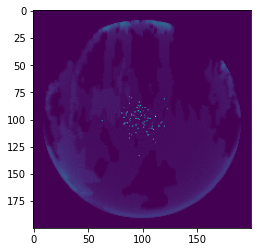

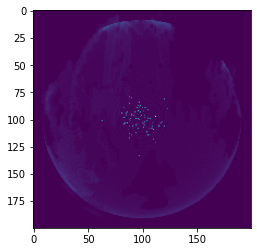

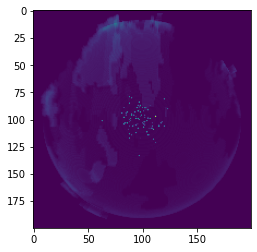

In [22]:
for i in range(3):
    tmp = cube2[i,:,:].sum(axis=(1,))
    #tmp = cube2[1,:,:,30]
    print(labels[i])
    fig, ax = plt.subplots(1, 1)
    ax.imshow(tmp)

Write individual images

In [23]:
for i in range(3):
    print(labels[i])
    hdul = fits.HDUList()
    hdul.append(fits.PrimaryHDU())
    hdul.append(fits.ImageHDU(data=cube2[i,:,:,:].sum(axis=(1,))))
    #hdul.append(fits.ImageHDU(data=cube2[i,:,:,30]))
    hdul.writeto('/local/home/vleboute/ownCloud/MULTIGRIS/output_{}.fits'.format(i), overwrite=True)
hdul = fits.HDUList()
hdul.append(fits.PrimaryHDU())
hdul.append(fits.ImageHDU(data=cube2[1,:,:,:].sum(axis=(1,))/cube2[2,:,:,:].sum(axis=(1,))))
hdul.writeto('/local/home/vleboute/ownCloud/MULTIGRIS/output_12.fits', overwrite=True)

O  3 5006.84A_x
S  2 6716.44A_x
C  2 157.636m_x


/tmp/ipykernel_248936/932184369.py:10: RuntimeWarning: invalid value encountered in true_divide
  hdul.append(fits.ImageHDU(data=cube2[1,:,:,:].sum(axis=(1,))/cube2[2,:,:,:].sum(axis=(1,))))


## Check results
***

Check result with DS9

May need to install:
- sudo apt install python3-pyds9


In [24]:
#do this only once and repeat next block if needed
import pyds9
d = pyds9.ds9()

AttributeError: module 'xpa' has no attribute 'xpaaccess'

In [ ]:
#d.set_np2arr(cube2[0,:,:,:].sum(axis=(1,)))
d.set('rgb')
d.set('rgb channel red')
d.set('file output_0.fits')
d.set('rgb channel green')
d.set('file output_1.fits')
d.set('rgb channel blue')
d.set('file output_2.fits')
d.set('zoom to fit')
d.set('scale linear')
d.set('colorbar no')
d.set('regions command {text 12 48 #text="2D projection" font="times 18 bold" color=white}')
d.set("regions command {text 13 45 #text='[SII] 6716A' font='times 14 bold' color=red}")
d.set("regions command {text 13 42 #text='[OIII] 5007A' font='times 14 bold' color=green}")
d.set("regions command {text 13 39 #text='[CII]' font='times 14 bold' color=blue}")
d.set('saveimage png output_projected.png')

In [ ]:
Image.open('/local/home/vleboute/ownCloud/MULTIGRIS/output_projected.png') 